In [2]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [20]:
C_e_const = 2.0

In [3]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [4]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


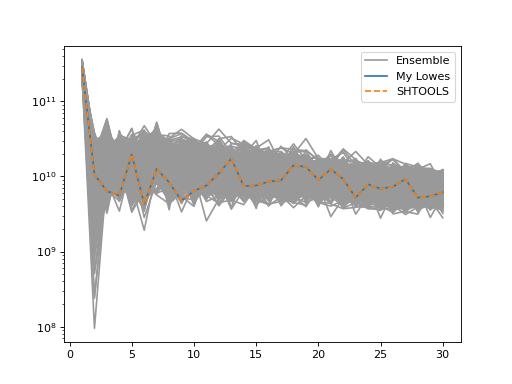

In [6]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("mikkel_tools/models_shc/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


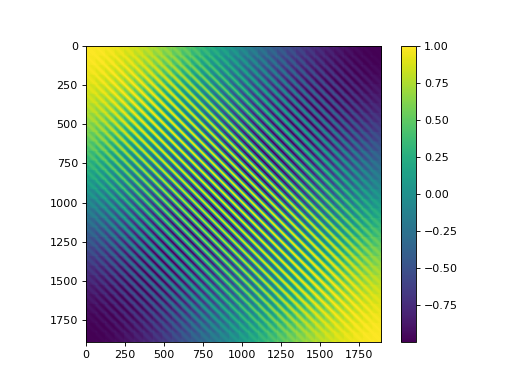

In [7]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [8]:
tap_to = 500
n_tap = n_max + tap_to

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

# Pos def find

In [9]:
init_lin = 40
N_lin = 6
tap_fac = 25

<IPython.core.display.Javascript object>


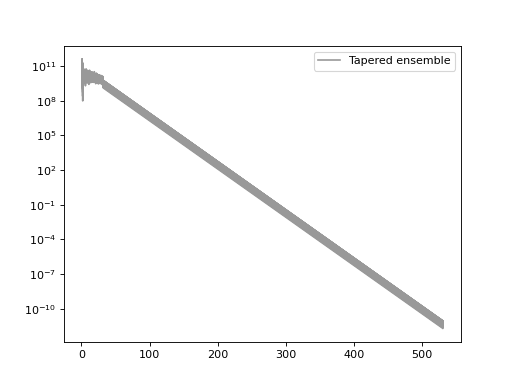

PD:  True


In [10]:
lin_exp = np.linspace(0,24,tap_to)
tap_exp = (0.5*np.exp(-100*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)

R_add = R[-1,:]*tap_exp
R_tap = np.vstack((R,R_add))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

In [11]:
C_Br_model = np.mean(C_Br,axis=2)

<IPython.core.display.Javascript object>


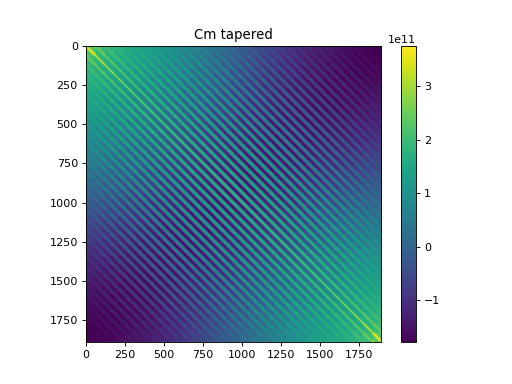

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


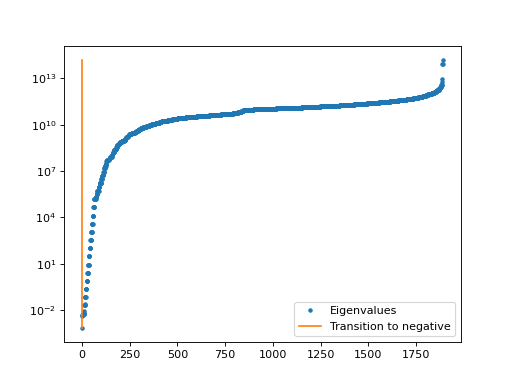

In [12]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Swarm observations through VirES VRE

In [13]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [14]:
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst"] # IMF
use_models = ["M_use = 'LCS-1' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary' + 'MIO_SHA_2C'"]

In [15]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models=use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M")

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,15))

ds = data.as_xarray()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:09, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.477MB)


In [16]:
SZA_angle = 10
Kp_max = 2
dDst_max = 2
QDlat_max = 55

# Index sorting to get rid of observations that do not live up to the set criteria
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  abs(np.diff(ds.Dst.values,prepend=0))/(5/60) <=dDst_max))

In [18]:
obs_sat = SDSS(comment, N_SH = shc_g)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] #+ ds["B_NEC_M_use"].values[:,2][idx_sort] 

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.data)
print(obs_sat.grid_N)

1333


# System equations

In [21]:
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 5.014 minutes 
Total elapsed time: 5.014 minutes 
Variance: 251721201971.897
Mean: 7504.401
Max: 4712338.278
Min: -2211201.098
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 4.687 minutes 
Total elapsed time: 9.701 minutes 
Variance: 226166221075.827
Mean: 4536.672
Max: 2460279.503
Min: -2298145.753
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 4.745 minutes 
Total elapsed time: 14.447 minutes 
Variance: 248532584264.209
Mean: 2258.279
Max: 3871314.684
Min: -4442400.157
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 4.846 minutes 
Total elapsed time: 19.292 minutes 
Variance: 233819543042.822
Mean: 9255.649
Max: 1658719.379
Min: -1389946.283
Run nr.: 4


Seqsim RMSE:	 [[3.95365497 3.95009395

<IPython.core.display.Javascript object>


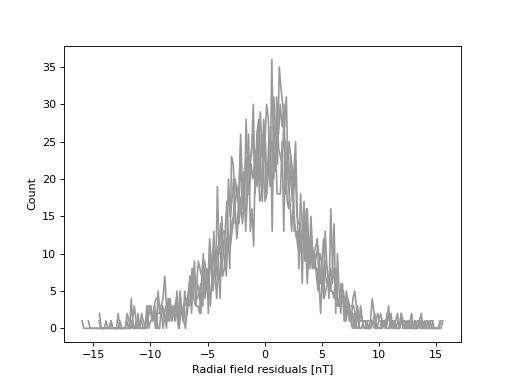

In [23]:
N_sim = 4
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [24]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [25]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


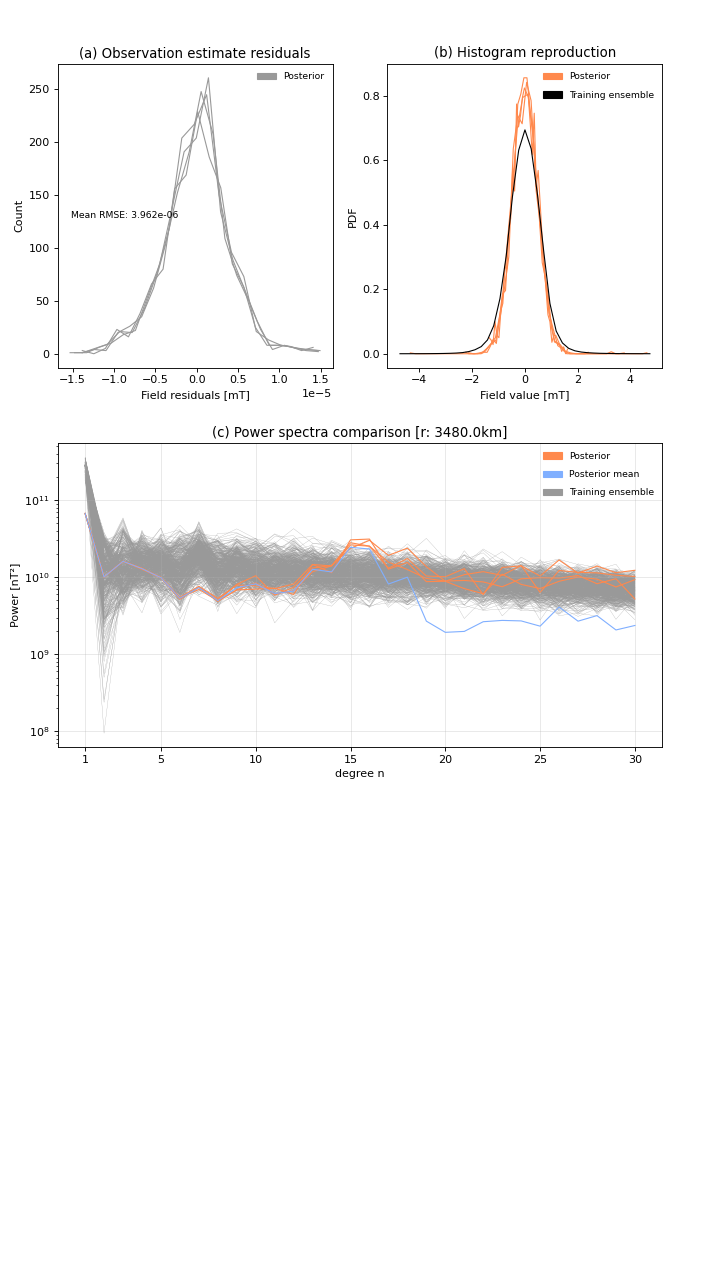

In [30]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = 1.0, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "core_sh30_ens_con", save_dpi = 300)

In [39]:
list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]

m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

idx_min = []
for coord in list_coord:
    idx_min.append(np.sum(np.abs(m_coord_sph - coord),axis=1).argmin())
    
print(idx_min)

m_hists_coord = m_coord_sph[idx_min]

m_hists = core.m_DSS[idx_min,:]

[915, 1225, 480, 215]


In [40]:
left=0.08
bottom=0.12
right=0.92
top=0.95
wspace = 0.2
hspace=0.25

color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)

<IPython.core.display.Javascript object>


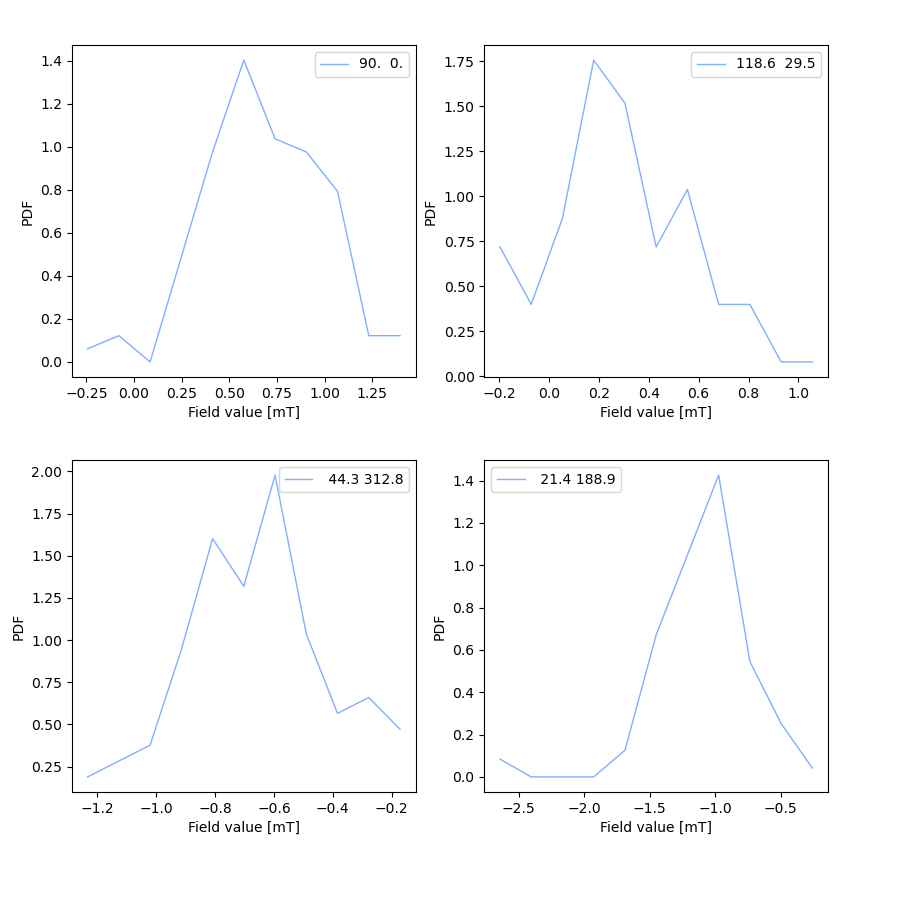

In [44]:
m_hists_scale = m_hists*10**(-6)

tile_size_row = 2
tile_size_column = 2

label_fontsize = 10

fig = plt.figure(figsize=(9,9)) # Initiate figure with constrained layout
# Generate ratio lists
h_ratio = [1]*tile_size_row
w_ratio = [1]*tile_size_column
gs = fig.add_gridspec(tile_size_row, tile_size_column, height_ratios=h_ratio, width_ratios=w_ratio) # Add x-by-y grid

for i in np.arange(0,list_coord.shape[0]):

    ax = fig.add_subplot(gs[i])
    
    y,binEdges=np.histogram(m_hists_scale[i,:],bins=11,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    ax.plot(bincenters, y, '-', color = color_rgb_zesty_neg, 
            label='{}'.format(str(np.round(m_hists_coord[i,:],decimals=1))).lstrip('[').rstrip(']'),
            linewidth = 1)

    #ax.set_title('test')
    #ax.annotate("test", (0.05, 0.5), xycoords='axes fraction', va='center', fontsize = label_fontsize)
    ax.set_xlabel("Field value [mT]")
    ax.set_ylabel("PDF")
    ax.legend(loc='best', fontsize = label_fontsize)
    

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

In [28]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


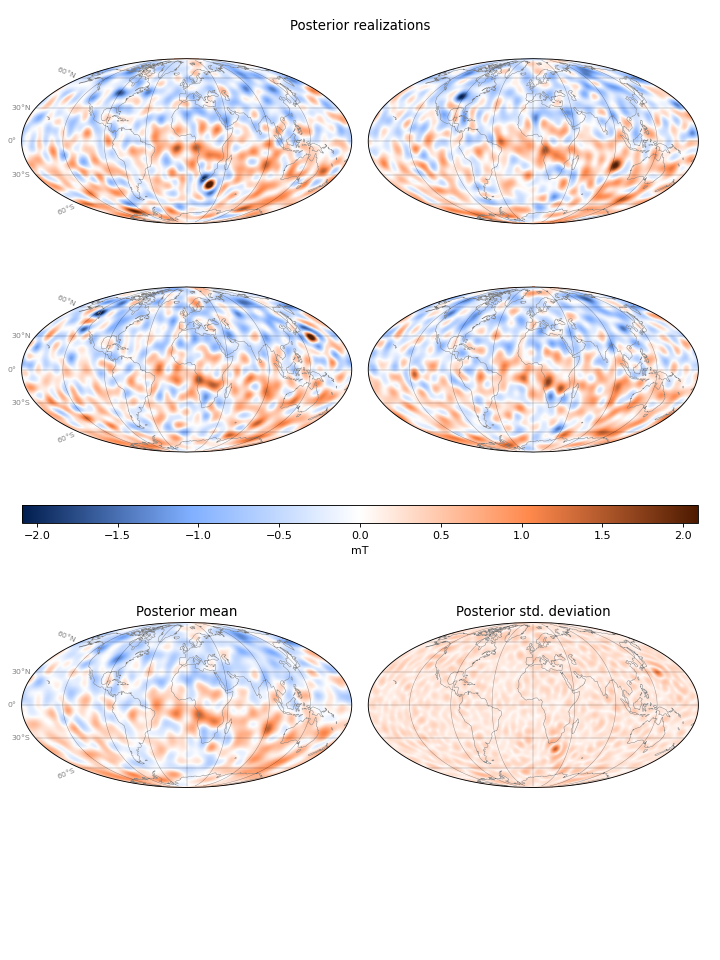

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
